<a name="0"></a> 

# Time Series Forecasting 


The dataset used for this task is a Kaggle dataset consisting of daily climate measurements for a city called Delhi in India including mean temperature, humidity, wind speed, and mean pressure. This task will take the humidity and wind speed measurements as two univariate time series and predict forecasts for each sequence. 

* [Dataset Link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data) 

---

## Models 

* **ARIMA: Autoregressive Integrated Moving Average** 
* **RNN: Recurrent Neural Network** 
* **CNN: Temporal Convolutional Neural Network** 

---

## Notebook Outline 

* [1. Load and Plot Time Series](#1) 
* [2. Exploratory Analysis](#2) 
* [3. Forecasting Humidity](#3) 
  * [3.1 Autoregressive Integrated Moving Average](#3-1) 
  * [3.2 Recurrent Neural Network](#3-2) 
  * [3.3 Convolutional Neural Network](#3-3) 
* [4. Forecasting Wind Speed](#4) 
  * [4.1 Autoregressive Integrated Moving Average](#4-1) 
  * [4.2 Recurrent Neural Network](#4-2) 
  * [4.3 Convolutional Neural Network](#4-3) 
* [5. Summary and Conclusion](#5) 

---

In [1]:
import os 
os.chdir('../') 

import warnings 
warnings.filterwarnings('ignore') 

from dspML import data, plot, utils 
from dspML.preprocessing import sequence 
from dspML.models.sequence import arima, nnetfc 
from dspML.evaluation import ForecastEval 

<a name="1"></a> 

# 1. Load and Plot Time Series 

[Outline](#0) 



In [2]:
# load data 
df = data.Climate.full() 
df.drop(['meantemp', 'meanpressure'], axis=1, inplace=True) 
print('Data Dimensions: ', df.shape) 
df.head() 

Data Dimensions:  (1576, 2)


,humidity,wind_speed
date,,
2013-01-01,84.500000,0.000000
2013-01-02,92.000000,2.980000
2013-01-03,87.000000,4.633333
2013-01-04,71.333333,1.233333
2013-01-05,86.833333,3.700000


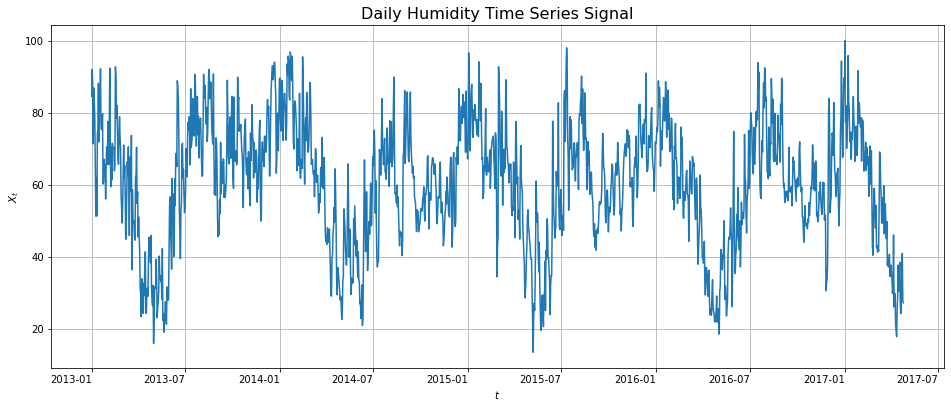

In [3]:
# plot humidity 
plot.signal_pd(
    df['humidity'], title='Daily Humidity Time Series Signal', figsize=(16, 7)
) 

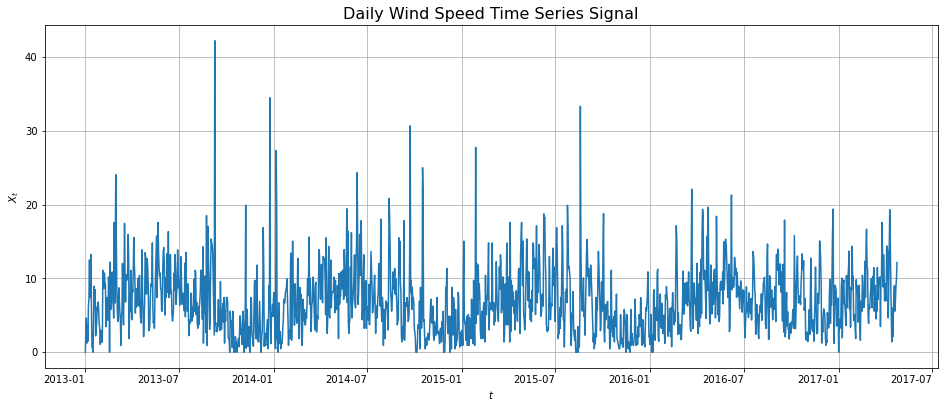

In [4]:
# plot wind speed 
plot.signal_pd(
    df['wind_speed'], title='Daily Wind Speed Time Series Signal', figsize=(16, 7)
) 

From observing the two time series, it looks like there may be a seasonal dependency in both series. Starting with humidity and then wind speed, exploratory analysis will determine if the series have a periodic dependency along with determining if the series are stationary or not. 

--- 

<a name="2"></a> 

# 2. Exploratory Analysis

[Outline](#0) | [Forecasting Humidity](#3) | [Forecasting Wind Speed](#4) 

---

## Section Outline 

* [2.1 Explore Humidity](#2-1) 
* [2.2 Explore Wind Speed](#2-2) 

---

<a name="2-1"></a> 

# 2.1 Explore Humidity 

* [Plot ACF and PACF](#2-1-1) 
* [ADF Test](#2-1-2) 
* [Compute and Plot First Difference](#2-1-3)

---

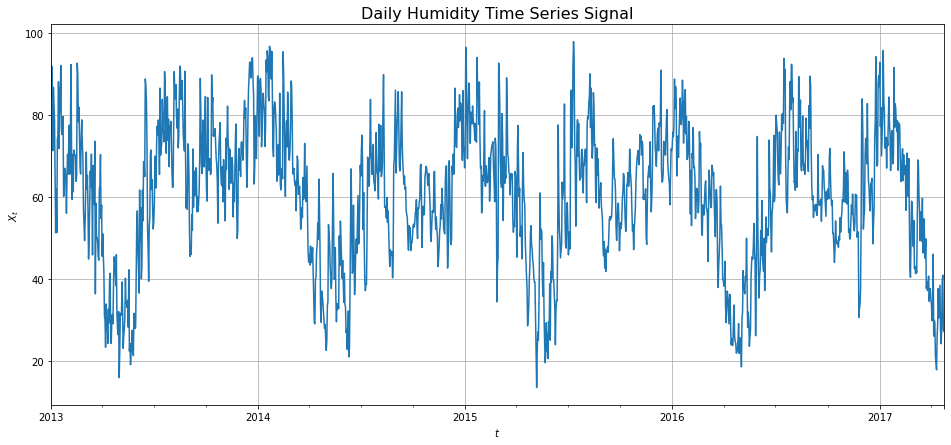

In [5]:
# extract humidity signal 
y = df['humidity'].resample('D').mean() 

plot.signal_pd(
    y, title='Daily Humidity Time Series Signal', figsize=(16, 7)
) 

<a name="2-1-1"></a> 

## Plot ACF and PACF 

[Outline](#0) | [Section Outline](#2) 

---

Since the data are humidity values taken every day, plot the autocorrelation and partial autocorrelation functions for a smaller number of lags to get a better visualization of the plots along with 400 lags to check if there is long term seasonal dependence. This will display if there might be any possible seasonal dependencies which will help in determining which models to use. 

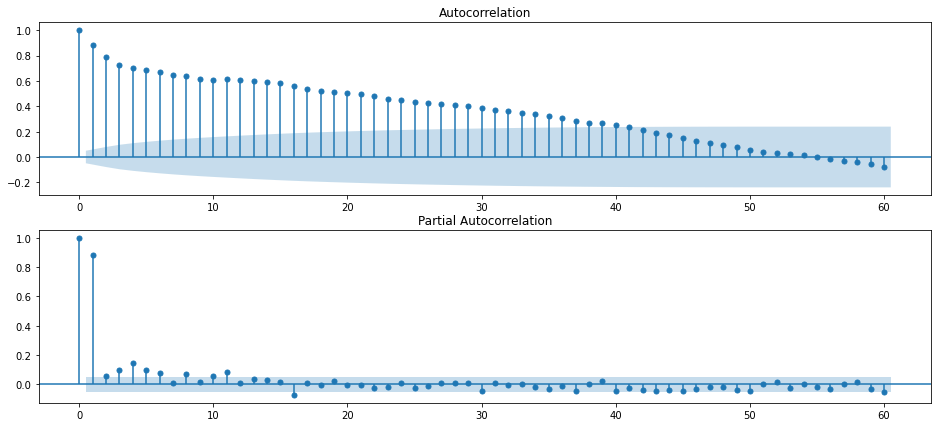

In [6]:
# plot ACF/PACF for 60 lags 
plot.p_acf(
    y, lags=60, figsize=(16, 7)
) 

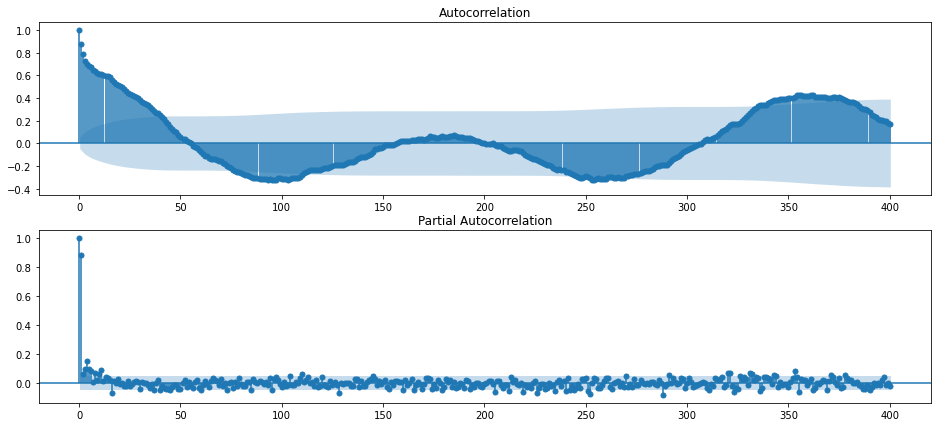

In [7]:
# plot ACF/PACF for 400 lags 
plot.p_acf(
    y, lags=400, figsize=(16, 7)
) 

The plots indicate that there are not any obvious long term dependencies in the series. For the plot with 60 lags, there looks like there is a strong dependence on lag 1 and possibly some dependence for lags 3, 4, and 5. 

---

<a name="2-1-2"></a> 

## ADF Test 

[Outline](#0) | [Section Outline](#2) 

--- 

The augmented Dickey-Fuller test is a unit root hypothesis test to test the hypothesis: 

$$
H_0: \phi = 0 \space vs. H_1: |\phi|<1
$$

The null hypothesis is that the observed series is that the process is a random walk where the alternative hypothesis is that the process is causal which would imply that the time series is stationary. 

In [8]:
# ADF test 
utils.ADF_test(y) 


Augmented Dickey-Fuller Test:

Test Statistic            -3.636648
p-val                      0.005098
Num. Lags                 15.000000
Num. Observations       1559.000000
Critical Value (1%)       -3.434551
Critical Value (5%)       -2.863396
Critical Value (10%)      -2.567758
dtype: float64

Conclusion:
The p-val <= 0.01 thus, the series is stationary


---

<a name="2-1-3"></a> 

## Compute and Plot First Difference 

[Outline](#0) | [Section Outline](#2) 

--- 

Compute the first order difference and plot. Then compute the ACF and PACF of the first difference and plot. Then conduct the ADF test. 

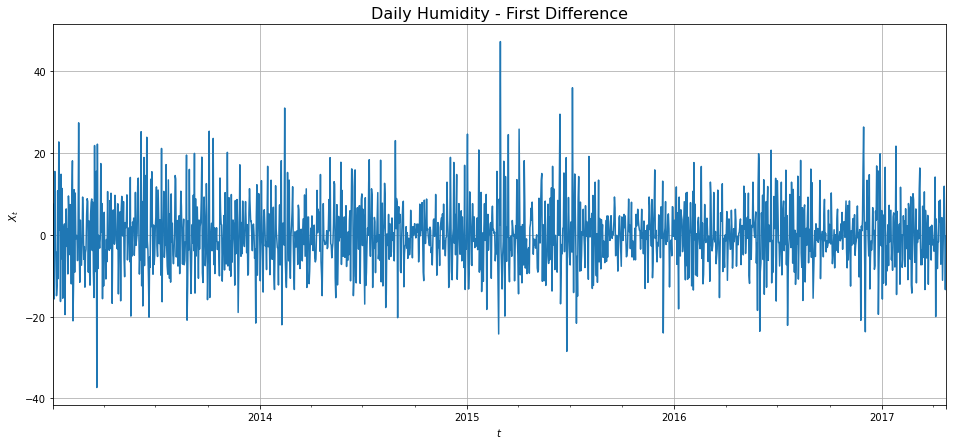

In [9]:
# first difference 
y1 = y.diff().iloc[1:] 

plot.signal_pd(
    y1, title='Daily Humidity - First Difference', figsize=(16, 7)
) 

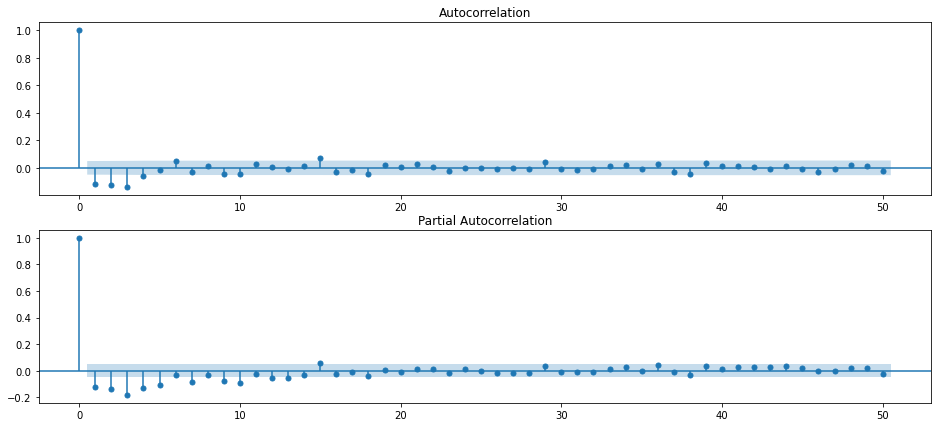

In [10]:
# plot ACF/PACF
plot.p_acf(
    y1, lags=50, figsize=(16, 7)
) 

In [11]:
# ADF test 
utils.ADF_test(y1) 


Augmented Dickey-Fuller Test:

Test Statistic         -1.335601e+01
p-val                   5.547009e-25
Num. Lags               1.400000e+01
Num. Observations       1.559000e+03
Critical Value (1%)    -3.434551e+00
Critical Value (5%)    -2.863396e+00
Critical Value (10%)   -2.567758e+00
dtype: float64

Conclusion:
The p-val <= 0.01 thus, the series is stationary


---

The first order difference $\nabla Y_t$ yields a stationary process that seems like it could be a white noise process. Since both the ACF and PACF of $\nabla Y_t$ appear to tail off, the model will be $ARIMA(p, d, q)$ where $d=1$. The other model orders will be determined when fitting the model to account for parameter redundancy. 

---

<a name="2-2"></a> 

# 2.2 Explore Wind Speed 

[Section Outline](#2) 

* [Plot ACF and PACF](#2-2-1) 
* [ADF Test](#2-2-2) 
* [Compute and Plot First Difference](#2-2-3) 

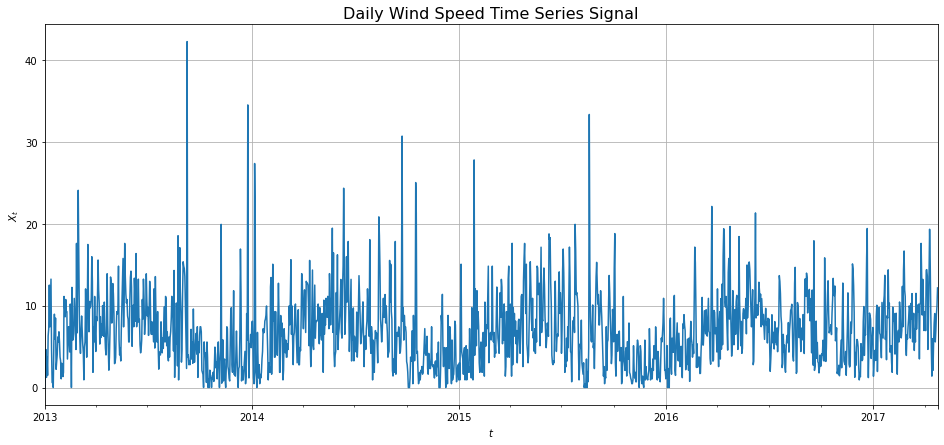

In [12]:
# extract wind speed signal 
y = df['wind_speed'].resample('D').mean() 

plot.signal_pd(
    y, title='Daily Wind Speed Time Series Signal', figsize=(16, 7)
) 

<a name="2-2-1"></a> 

## Plot ACF and PACF 

[Outline](#0) | [Section Outline](#2) 

---

Since the data are humidity values taken every day, plot the autocorrelation and partial autocorrelation functions for a smaller number of lags to get a better visualization of the plots along with 400 lags to check if there is long term seasonal dependence. This will display if there might be any possible seasonal dependencies which will help in determining which models to use. 

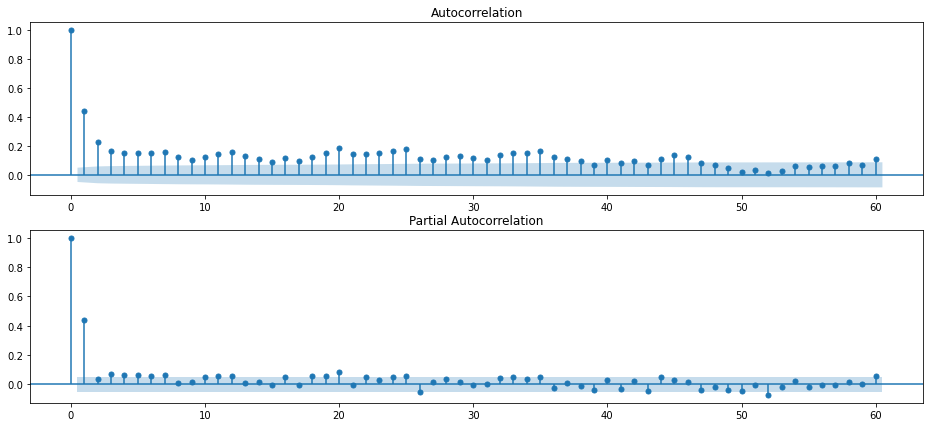

In [13]:
# plot ACF/PACF for 60 lags 
plot.p_acf(
    y, lags=60, figsize=(16, 7)
) 

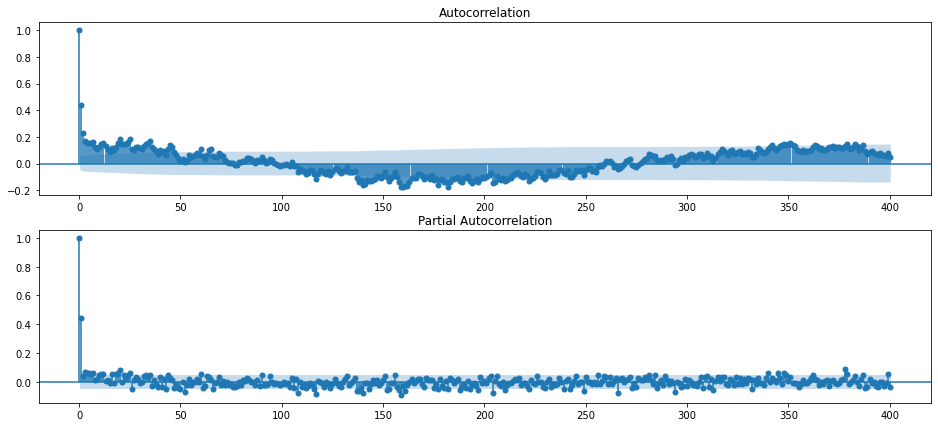

In [14]:
# plot ACF/PACF for 400 lags 
plot.p_acf(
    y, lags=400, figsize=(16, 7)
) 

The plots don't seem to indicate any obvious long term dependencies based on the partial autocorrelation plots. 

---

<a name="2-2-2"></a> 

## ADF Test 

[Outline](#0) | [Section Outline](#2) 

--- 

The augmented Dickey-Fuller test is a unit root hypothesis test to test the hypothesis: 

$$
H_0: \phi = 0 \space vs. H_1: |\phi|<1
$$

The null hypothesis is that the observed series is that the process is a random walk where the alternative hypothesis is that the process is causal which would imply that the time series is stationary. 

In [15]:
# ADF test 
utils.ADF_test(y) 


Augmented Dickey-Fuller Test:

Test Statistic            -4.005864
p-val                      0.001380
Num. Lags                 24.000000
Num. Observations       1550.000000
Critical Value (1%)       -3.434576
Critical Value (5%)       -2.863406
Critical Value (10%)      -2.567764
dtype: float64

Conclusion:
The p-val <= 0.01 thus, the series is stationary


---

<a name="2-2-3"></a> 

## Compute and Plot First Difference

[Outline](#0) | [Section Outline](#2) 

---

Compute the first order difference and plot. Then compute the ACF and PACF of the first difference and plot. Then conduct the ADF test. 

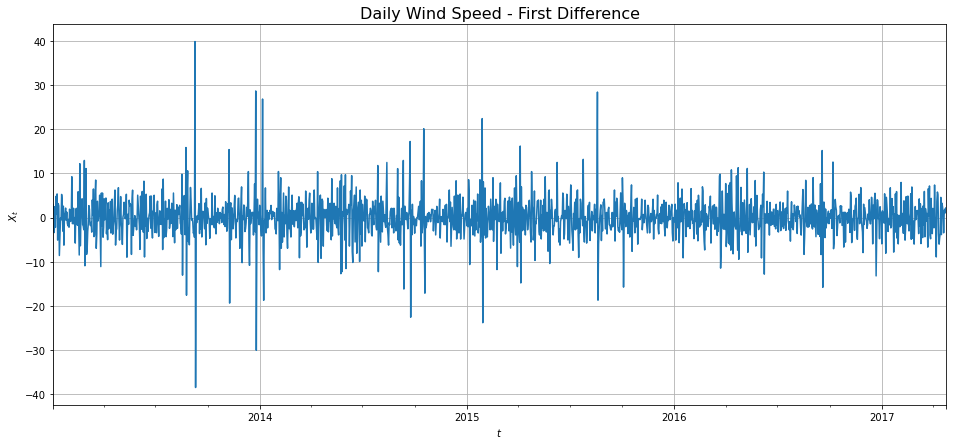

In [16]:
# first difference 
y1 = y.diff().iloc[1:] 

plot.signal_pd(
    y1, title='Daily Wind Speed - First Difference', figsize=(16, 7)
) 

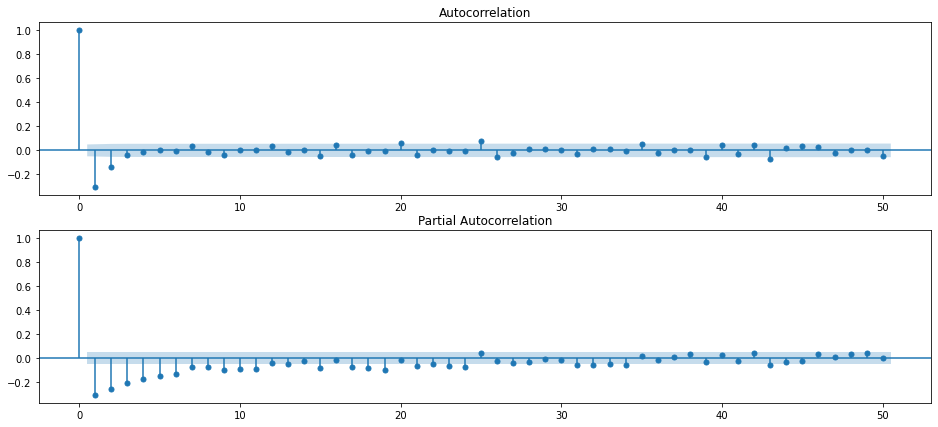

In [17]:
# ACF/PACF
plot.p_acf(
    y1, lags=50, figsize=(16, 7)
) 

In [18]:
# ADF test 
utils.ADF_test(y1) 


Augmented Dickey-Fuller Test:

Test Statistic         -1.329051e+01
p-val                   7.379173e-25
Num. Lags               2.400000e+01
Num. Observations       1.549000e+03
Critical Value (1%)    -3.434579e+00
Critical Value (5%)    -2.863408e+00
Critical Value (10%)   -2.567764e+00
dtype: float64

Conclusion:
The p-val <= 0.01 thus, the series is stationary


---

The first order difference $\nabla Y_t$ yields a stationary process that seems like it could be a white noise process. Since the ACF cuts off after lag $h=3$ and the PACF appears to tail off, the model will be $IMA(1, 3)$. 

---

<a name="3"></a> 

# 3. Forecasting Humidity 

[Outline](#0) | [EDA Humidity](#2-1) | [Forecasting Wind Speed](#4) | [Summary](#5) 

---

## Section Outline 

* [3.1 Autoregressive Integrated Moving Average](#3-1) 
* [3.2 Recurrent Neural Network](#3-2) 
* [3.3 Convolutional Neural Network](#3-3) 

---



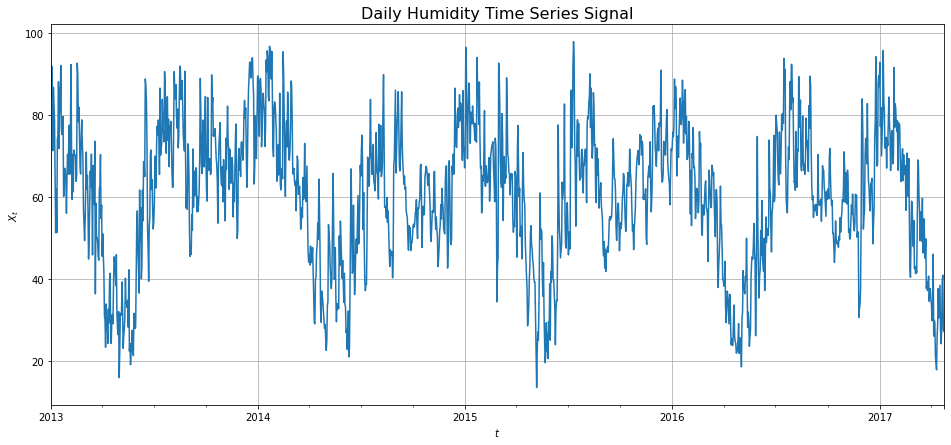

In [19]:
# extract humidity signal 
y = df['humidity'].resample('D').mean() 

plot.signal_pd(
    y, title='Daily Humidity Time Series Signal', figsize=(16, 7)
) 

<a name="3-1"></a> 

# 3.1 Autoregressive Integrated Moving Average 

[Outline](#0) | [Section Outline](#3) | [Section 4.1](#4-1) 

---

## Topic Outline 

* [Define Model](#3-1-1) 
* [Residual Analysis](#3-1-2) 
* [In-Sample Predictions](#3-1-3) 
* [Predict and Evaluate 7-Day Forecast](#3-1-4) 
* [Plot Predicted Forecast](#3-1-5) 

---

## Split Data 

Split the data such that the last week is saved for evaluation for forecasting the "future". 

In [20]:
# split data 
fc_hzn = 7 
y_train, y_test = sequence.temporal_split(y, fc_hzn) 

<a name="3-1-1"></a> 

## Define Model 

[Topic Outline](#3-1) 

In [21]:
# define ARIMA 
model = arima.ARIMA(
    y_train, 
    order=((1, 0, 1), 1, (1, 1)), 
    seasonal_order=(0, 0, 0, 0)
) 

                                 SARIMAX Results                                 
Dep. Variable:                  humidity   No. Observations:                 1568
Model:             SARIMAX([1, 3], 1, 2)   Log Likelihood               -5421.772
Date:                   Wed, 30 Sep 2020   AIC                          10853.545
Time:                           12:05:53   BIC                          10880.320
Sample:                       01-01-2013   HQIC                         10863.498
                            - 04-17-2017                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5221      0.055      9.575      0.000       0.415       0.629
ar.L3         -0.0675      0.027     -2.511      0.012      -0.120      -0.015
ma.L1         -0.7440      0

All orders for the model parameters are significant. 

--- 

<a name="3-1-2"></a> 

## Residual Analysis 

[Topic Outline](#3-1) 

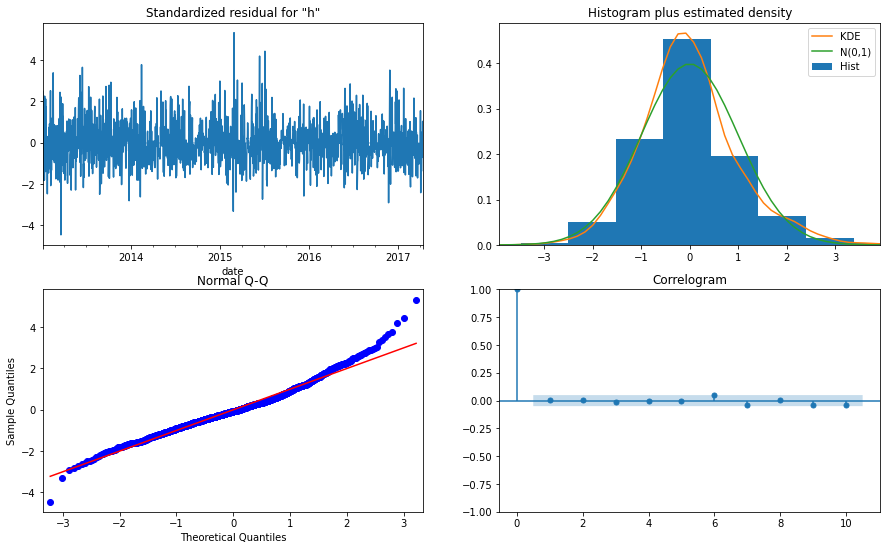

In [22]:
# residual analysis 
resids = model.plot_diagnostics(figsize=(15, 9)) 

The residuals seem to follow a white noise process. 

--- 

<a name="3-1-3"></a> 

## In-Sample Predictions 

[Topic Outline](#3-1) 

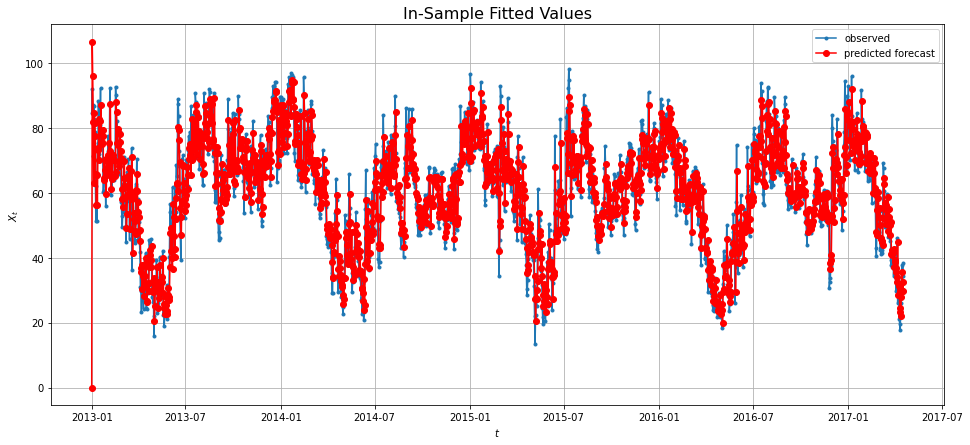

In [23]:
plot.time_series_forecast(
    signal=y_train, 
    p_forecast=model.fittedvalues, 
    title='In-Sample Fitted Values', 
    figsize=(16, 7)
) 

The fitted values seem to be very closely lined up with the real values of the time series. 

--- 

<a name="3-1-4"></a> 

## Predict and Evaluate 7-Day Forecast 

[Topic Outline](#3-1) 

In [24]:
# predict forecast 
y_pred = model.forecast(steps=7) 

# evaluation 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 56.38
RMSE = 7.51


<a name="3-1-5"></a> 

## Plot Predicted Forecast 

[Topic Outline](#3-1) | [Summary](#5) 

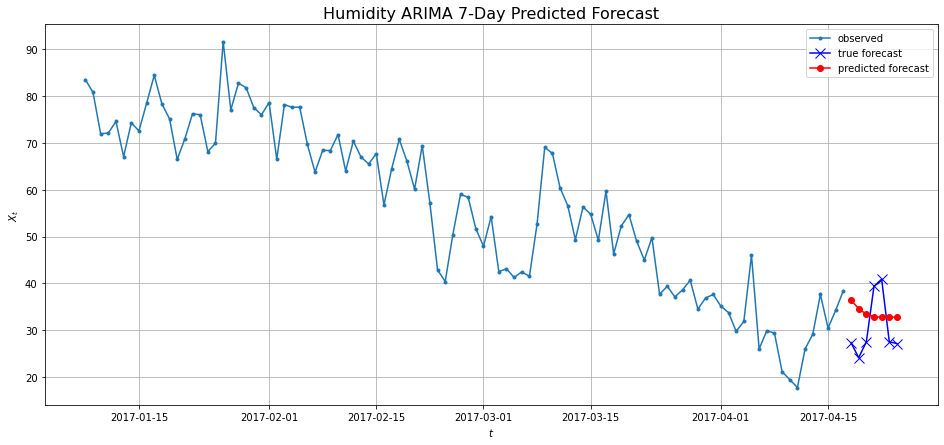

In [25]:
plot.time_series_forecast(
    signal=y_train.iloc[-100:], 
    signal_test=y_test, 
    p_forecast=y_pred, 
    title='Humidity ARIMA 7-Day Predicted Forecast', 
    figsize=(16, 7)
) 

---

<a name="3-2"></a> 

# 3.2 Recurrent Neural Network 

[Outline](#0) | [Section Outline](#3) | [Section 4.2](#4-2) 

---

## Topic Outline 

* [Preprocess Data](#3-2-1) 
* [Load Fitted Model](#3-2-2) 
* [Predict and Evaluate 7-Day Forecast](#3-2-3) 
* [Plot Predicted Forecast](#3-2-4) 

---

<a name="3-2-1"></a> 

## Preprocess Data 

For neural networks, the time series needs to be normalized and converted into sequences. The sequences and the response come from a sliding window that steps through time 1 time step at a time and uses a defined number of observations to predict the last value of the window. 

In [26]:
# extract humidity signal 
signal = df['humidity'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


---

<a name="3-2-2"></a> 

## Load Fitted Model 

[Topic Outline](#3-2) 

---

The loaded model has been fit to the data and saved so the results will be the same every time. The model will be fit with early stopping where if there is no improvement in 50 epochs training will stop and the weights from the best epoch will be recovered. There will be a total of 1000 epochs so verbose will be set to 0 so it won't print a progress bar and the loss for every epoch. 

In [27]:
model = nnetfc.load_humidity(recurrent=True) 
model.summary() 

Model: "Recurrent_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


<a name="3-2-3"></a> 

## Predict and Evaluate 7-Day Forecast 

[Topic Outline](#3-2) 

---

After the forecast has been predicted, the dates from the true future values will be used to align the forecast prediction and then all of the signals will be transformed back to original values to compute the mean squared error and visualize the forecast. 

In [28]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 120.13
RMSE = 10.96


<a name="3-2-4"></a> 

## Plot Predicted Forecast 

[Topic Outline](#3-2) | [Summary](#5) 

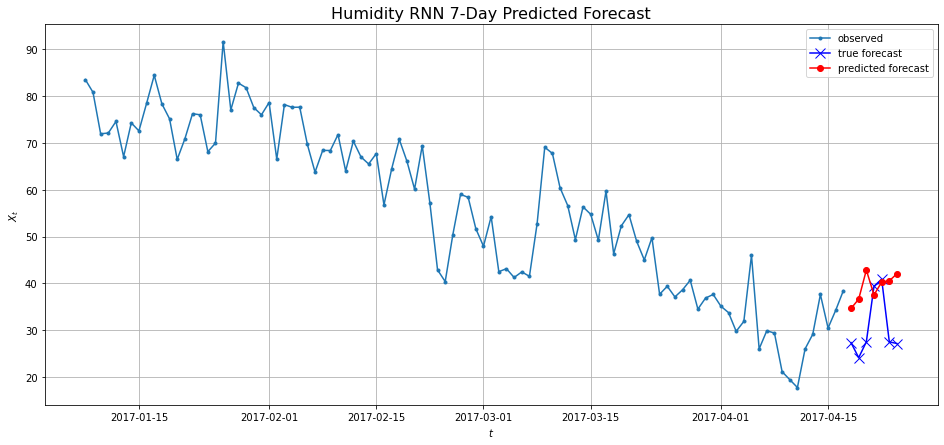

In [29]:
plot.time_series_forecast(
    signal=y.iloc[-100:], 
    signal_test=y_test, 
    p_forecast=y_pred, 
    title='Humidity RNN 7-Day Predicted Forecast', 
    figsize=(16, 7)
) 

---

<a name="3-3"></a> 

# 3.3 Convolutional Neural Network 

[Outline](#0) | [Section Outline](#3) | [Section 4.3](#4-3) 

---

## Topic Outline 

* [Preprocess Data](#3-3-1) 
* [Load Fitted Model](#3-3-2) 
* [Predict and Evaluate 7-Day Forecast](#3-3-3) 
* [Plot Predicted Forecast](#3-3-4) 

---

<a name="3-3-1"></a> 

## Preprocess Data 

Preprocessing is exactly the same as for recurrent networks. 

In [30]:
# extract humidity signal 
signal = df['humidity'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


<a name="3-3-2"></a> 

## Load Fitted Model 

[Topic Outline](#3-3) 

---

The loaded model has been fit to the data and saved so the results will be the same every time. The model will be fit with early stopping where if there is no improvement in 50 epochs training will stop and the weights from the best epoch will be recovered. There will be a total of 1000 epochs so verbose will be set to 0 so it won't print a progress bar and the loss for every epoch. 

In [31]:
model = nnetfc.load_humidity(recurrent=False) 
model.summary() 

Model: "Convolutional_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
MaxPool (MaxPooling1D)       (None, None, 32)          0         
_________________________________________________________________
Dense (Dense)                (None, None, 5)           165       
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           6         
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


<a name="3-3-3"></a> 

## Predict and Evaluate 7-Day Forecast

[Topic Outline](#3-2) 

In [32]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 63.64
RMSE = 7.98


<a name="3-3-4"></a> 

## Plot Predicted Forecast 

[Topic Outline](#3-2) | [Summary](#5) 

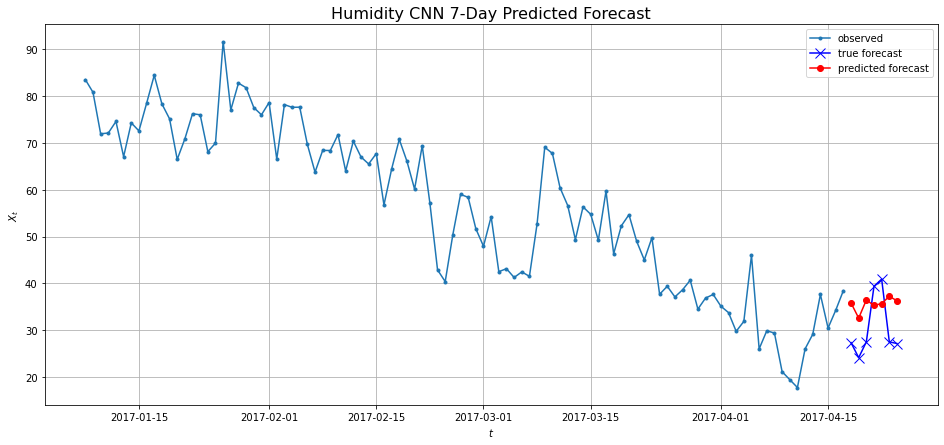

In [33]:
plot.time_series_forecast(
    signal=y.iloc[-100:], 
    signal_test=y_test, 
    p_forecast=y_pred, 
    title='Humidity CNN 7-Day Predicted Forecast', 
    figsize=(16, 7)
) 

---

<a name="4"></a> 

# 4. Forecasting Wind Speed 

[Outline](#0) | [EDA Wind Speed](#2-2) | [Forecasting Humidity](#3) | [Summary](#5) 

---

## Section Outline 

* [4.1 Autoregressive Integrated Moving Average](#4-1) 
* [4.2 Recurrent Neural Network](#4-2) 
* [4.3 Convolutional Neural Network](#4-3) 

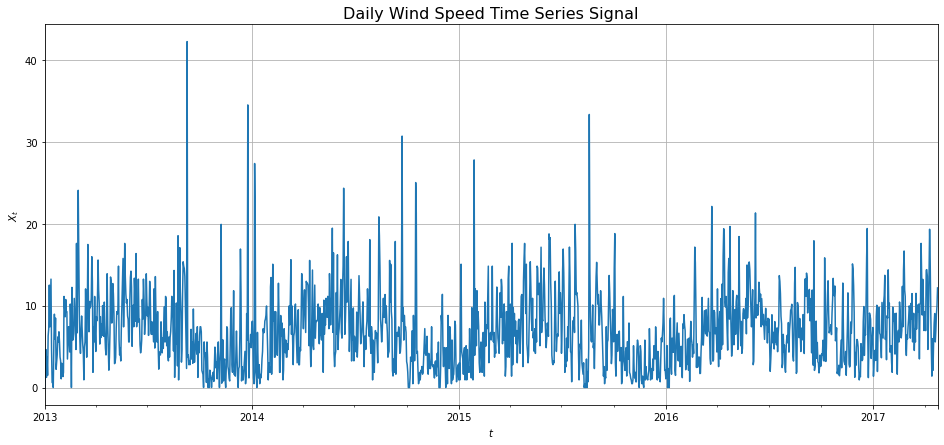

In [34]:
# extract wind speed signal 
y = df['wind_speed'].resample('D').mean() 

plot.signal_pd(
    y, title='Daily Wind Speed Time Series Signal', figsize=(16, 7)
) 

<a name="4-1"></a> 

# 4.1 Autoregressive Integrated Moving Average 

[Outline](#0) | [Section Outline](#4) | [Section 3.1](#3-1) 

---

## Topic Outline 

* [Define Model](#4-1-1) 
* [Residual Analysis](#4-1-2) 
* [In-Sample Predictions](#4-1-3) 
* [Predict and Evaluate 7-Day Forecast](#4-1-4) 
* [Plot Predicted Forecast](#4-1-5) 

--- 

## Split Data 

Split the data such that the last week is saved for evaluation for forecasting the "future". 

In [35]:
# split data 
fc_hzn = 7 
y_train, y_test = sequence.temporal_split(y, fc_hzn) 

<a name="4-1-1"></a> 

## Define Model 

[Topic Outline](#4-1) 

In [36]:
# define ARIMA 
model = arima.ARIMA(
    y_train, 
    order=(0, 1, 3), 
    seasonal_order=(0, 0, 0, 0)
) 

                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                 1568
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -4380.997
Date:                Wed, 30 Sep 2020   AIC                           8769.994
Time:                        12:05:56   BIC                           8791.412
Sample:                    01-01-2013   HQIC                          8777.956
                         - 04-17-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7032      0.021    -33.934      0.000      -0.744      -0.663
ma.L2         -0.2811      0.024    -11.692      0.000      -0.328      -0.234
ma.L3         -0.0832      0.025     -3.378      0.0

---

All orders for the model parameters are significant. 

--- 

<a name="4-1-2"></a> 

## Residual Analysis 

[Topic Outline](#4-1) 

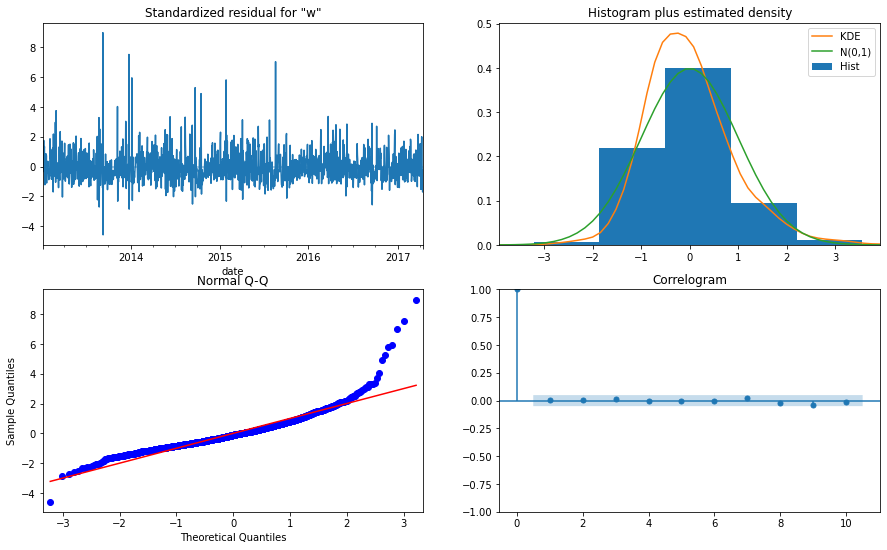

In [37]:
# residual analysis 
resids = model.plot_diagnostics(figsize=(15, 9)) 

The residuals seem to follow a white noise process. 

--- 

<a name="4-1-3"></a> 

## In-Sample Predictions 

[Topic Outline](#4-1) 

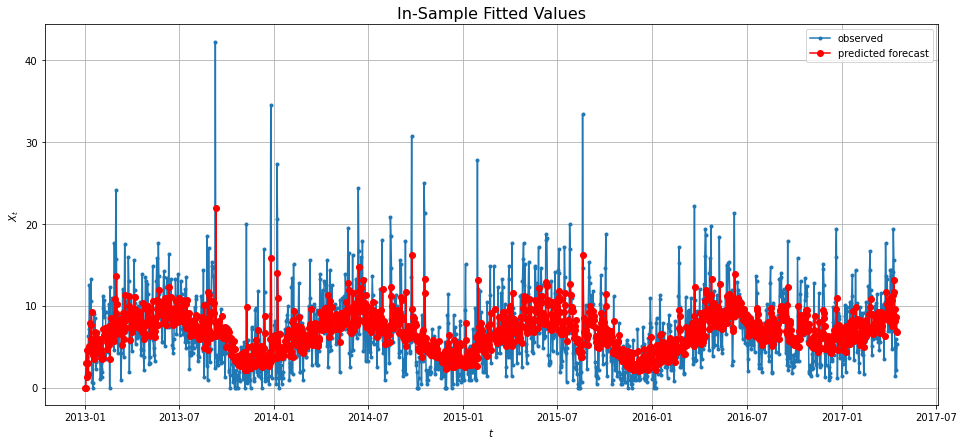

In [38]:
plot.time_series_forecast(
    signal=y_train, 
    p_forecast=model.fittedvalues, 
    title='In-Sample Fitted Values', 
    figsize=(16, 7)
) 

With the exception of extreme values, the fitted values seem to have a decent fit to the time series. 

--- 

<a name="4-1-4"></a> 

## Predict and Evaluate 7-Day Forecast

[Topic Outline](#4-1) 

In [39]:
# predict forecast 
y_pred = model.forecast(steps=7) 

# evaluation 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 3.81
RMSE = 1.95


<a name="4-1-5"></a> 

## Plot Predicted Forecast 

[Topic Outline](#4-1) | [Summary](#5) 

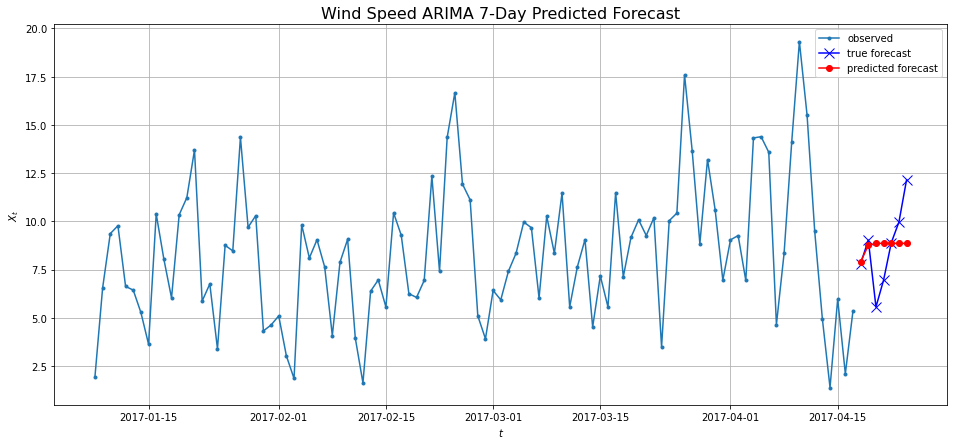

In [40]:
plot.time_series_forecast(
    signal=y_train.iloc[-100:], 
    signal_test=y_test, 
    p_forecast=y_pred, 
    title='Wind Speed ARIMA 7-Day Predicted Forecast', 
    figsize=(16, 7)
) 

---

<a name="4-2"></a> 

# 4.2 Recurrent Neural Network 

[Outline](#0) | [Section Outline](#4) | [Section 3.2](#3-2) 

--- 

## Topic Outline 

* [Preprocess Data](#4-2-1) 
* [Load Fitted Model](#4-2-2) 
* [Predict and Evaluate 7-Day Forecast](#4-2-3) 
* [Plot Predicted Forecast](#4-2-4) 

---

<a name="4-2-1"></a> 

## Preprocess Data 

For neural networks, the time series needs to be normalized and converted into sequences. The sequences and the response come from a sliding window that steps through time 1 time step at a time and uses a defined number of observations to predict the last value of the window. 

In [41]:
# extract humidity signal 
signal = df['wind_speed'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


---

<a name="4-2-2"></a> 

## Load Fitted Model 

[Topic Outline](#4-2) 

---

The loaded model has been fit to the data and saved so the results will be the same every time. The model will be fit with early stopping where if there is no improvement in 50 epochs training will stop and the weights from the best epoch will be recovered. There will be a total of 1000 epochs so verbose will be set to 0 so it won't print a progress bar and the loss for every epoch. 

In [42]:
model = nnetfc.load_wind_speed(recurrent=True) 
model.summary() 

Model: "Recurrent_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


<a name="4-2-3"></a> 

## Predict and Evaluate 7-Day Forecast 

[Topic Outline](#4-2) 

In [43]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 6.51
RMSE = 2.55


<a name="4-2-4"></a> 

## Plot Predicted Forecast 

[Topic Outline](#4-2) | [Summary](#5) 

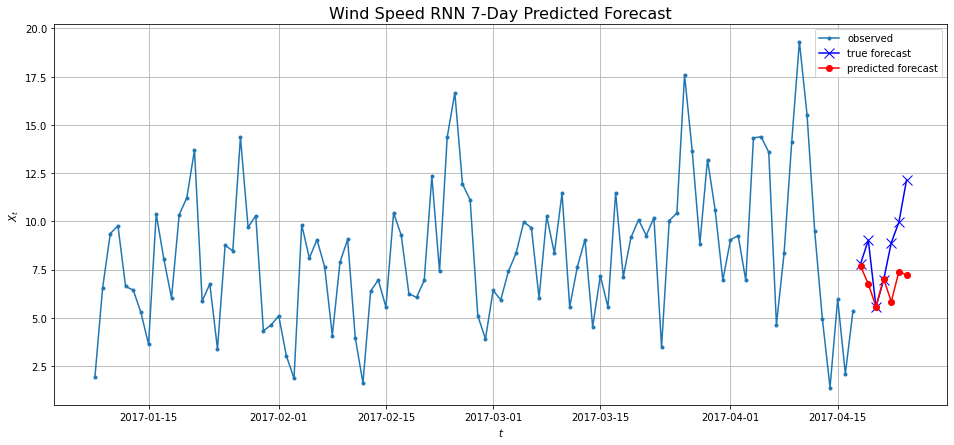

In [44]:
plot.time_series_forecast(
    signal=y.iloc[-100:], 
    signal_test=y_test, 
    p_forecast=y_pred, 
    title='Wind Speed RNN 7-Day Predicted Forecast', 
    figsize=(16, 7)
) 

---

<a name="4-3"></a> 

# 4.3 Convolutional Neural Network 

[Outline](#0) | [Section Outline](#4) | [Section 3.3](#3-3) 

--- 


## Topic Outline 

* [Preprocess Data](#4-3-1) 
* [Load Fitted Model](#4-3-2) 
* [Predict and Evaluate 7-Day Forecast](#4-3-3) 
* [Plot Predicted Forecast](#4-3-4) 

---

<a name="4-3-1"></a> 

## Preprocess Data 

Preprocessing is exactly the same as for recurrent networks. 

In [45]:
# extract humidity signal 
signal = df['wind_speed'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


---

<a name="4-3-2"></a> 

## Load Fitted Model 

[Topic Outline](#4-3) 

--- 

The loaded model has been fit to the data and saved so the results will be the same every time. The model will be fit with early stopping where if there is no improvement in 50 epochs training will stop and the weights from the best epoch will be recovered. There will be a total of 1000 epochs so verbose will be set to 0 so it won't print a progress bar and the loss for every epoch. 

In [46]:
model = nnetfc.load_wind_speed(recurrent=False) 
model.summary() 

Model: "Convolutional_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
MaxPool (MaxPooling1D)       (None, None, 32)          0         
_________________________________________________________________
Dense (Dense)                (None, None, 5)           165       
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           6         
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


<a name="4-3-3"></a> 

## Predict and Evaluate 7-Day Forecast 

[Topic Outline](#4-3) 

In [47]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 8.31
RMSE = 2.88


<a name="4-3-4"></a> 

## Plot Predicted Forecast 

[Topic Outline](#4-3) | [Summary](#5) 

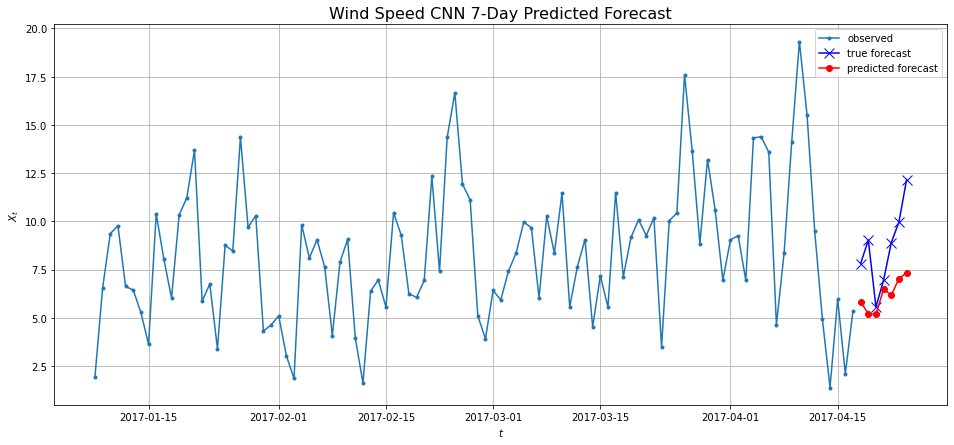

In [48]:
plot.time_series_forecast(
    signal=y.iloc[-100:], 
    signal_test=y_test, 
    p_forecast=y_pred, 
    title='Wind Speed CNN 7-Day Predicted Forecast', 
    figsize=(16, 7)
) 

---

<a name="5"></a> 

# 5. Summary and Conclusion 

[Outline](#0) | [Forecasting Humidity](#3) | [Forecasting Wind Speed](#4) 

--- 

## Forecasting Humidity 

For forecasting humidity, exploratory analysis indicated that there is no seasonal component in the series based on the autocorrelation and partial autocorrelationn functions. The augmented Dickey Fuller test indicates that the time series is stationary so the ARIMA model without a seasonal adjustment is implemented. For neural networks, a recurrent neural network with one Gated Recurrent Unit (GRU) layer is implemented and a convolutional network with one temporal convolutional layer followed by a max pooling layer and a dense layer before it reaches the output layer. 

The mean squared error and root mean squared errors for all three models are summarized in the table below. 

| Model   | MSE    | RMSE   |
| :-----: | :----: | :----: |
| ARIMA   | 56.38  | 7.51   |
| RNN     | 120.13 | 10.96  |
| CNN     | 63.64  | 7.98   | 


---

## Forecasting Wind Speed 

For forecasting wind speed, exploratory analysis yields the same results as that of the humidity time series and thus, the wind speed time series does not have a seasonal dependency and it is stationary. The models implemented are exactly the same. 


The mean squared error and root mean squared errors for all three models are summarized in the table below. 

| Model   | MSE    | RMSE   |
| :-----: | :----: | :----: |
| ARIMA   | 3.81   | 1.95   |
| RNN     | 6.51   | 2.55   |
| CNN     | 8.31   | 2.88   |


---

## Conslusion 

Based on the MSE and RMSE, the ARIMA models had the best performance for both the humidity and wind speed time series. While that seems promising, the plots of the actual forecast yield interesting results. 

For the **humidity time series**, the ARIMA model results in the lowest MSE/RMSE but when viewing the predicted forecast it shows that the predictions essentially lie along the average between all the actual future observations. This is a good estimate and if prediction intervals were included in this study the points would likely fall within the confidence bounds. For predictions based purely off where the predicted points lie, the recurrent and convolutional neural networks yield predicted forecasts that appear to be much more realistic than the ARIMA forecast since the predictions do not essentially create a flat line through the center of the points. 

[ARIMA Forecast](#3-1-5) | [RNN Forecast](#3-2-4) | [CNN Forecast](#3-3-4) 

For the **wind speed time series**, the ARIMA model again results in the lowest MSE/RMSE. The predictions for two steps in the future for the ARIMA model are very accurate and account for the varying observations in the predictions but after the two steps it flattens out like it did for the humidity forecast. The recurrent and convolutional neural networks yield similar results as they did for humidity. There was more error in predictions but the predicted forecasts appear to be more realistic based purely off of the values of predictions. 

[ARIMA Forecast](#4-1-5) | [RNN Forecast](#4-2-4) | [CNN Forecast](#4-3-4) 